In [1]:
# !pip install scikit-plot

# Import Necessary Libraries


In [2]:
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

# Reading the Dataset and analysis

In [3]:
train_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Training\\'

test_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Testing\\'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

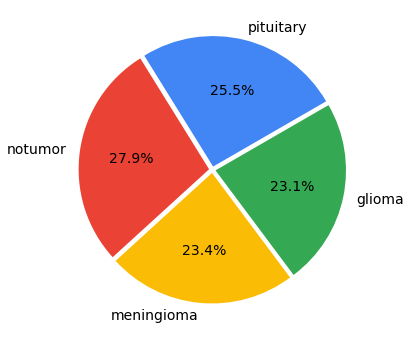

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# Defining Labels and loading dataset


In [5]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size=150

for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 749.38it/s]


In [6]:
X_train.shape #No of sample = 7023

(7023, 150, 150, 3)

In [7]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

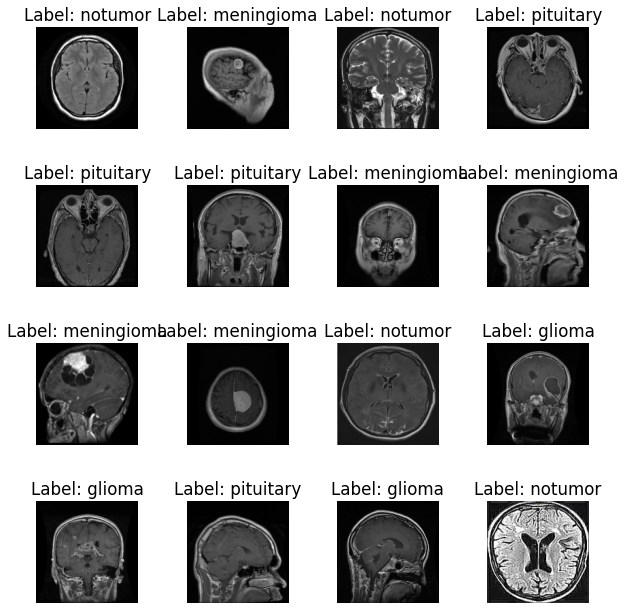

In [8]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Converting String Label to categorical


In [10]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

# Simple VGG16 Model


In [13]:
# Define the model
from tensorflow.keras.applications import VGG16
Base_model = VGG16(include_top= False, weights='imagenet',input_shape = (150, 150, 3), pooling='avg')
VGG16_model = Sequential()
VGG16_model.add(Base_model)
VGG16_model.add(Dense(256,activation='relu'))
VGG16_model.add(Dense(4,activation="softmax"))

In [15]:
VGG16_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 14,847,044
Trainable params: 14,847,044
Non-trainable params: 0
_________________________________________________________________


# Scaling Features : Train, Valid and Test

In [16]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# Training the model

In [17]:
history = VGG16_model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=64,
                   epochs=50,
                   verbose=1)

Epoch 1/50
79/79 [==============================] - 243s 3s/step - loss: 2.4375 - accuracy: 0.2751 - val_loss: 1.4137 - val_accuracy: 0.3452
Epoch 2/50
79/79 [==============================] - 195s 2s/step - loss: 1.3094 - accuracy: 0.3973 - val_loss: 0.8993 - val_accuracy: 0.6139
Epoch 3/50
79/79 [==============================] - 195s 2s/step - loss: 0.9146 - accuracy: 0.6087 - val_loss: 0.7967 - val_accuracy: 0.6690
Epoch 4/50
79/79 [==============================] - 195s 2s/step - loss: 0.7632 - accuracy: 0.6711 - val_loss: 0.6220 - val_accuracy: 0.7260
Epoch 5/50
79/79 [==============================] - 194s 2s/step - loss: 0.6268 - accuracy: 0.7461 - val_loss: 0.5905 - val_accuracy: 0.7349
Epoch 6/50
79/79 [==============================] - 194s 2s/step - loss: 0.5079 - accuracy: 0.7908 - val_loss: 0.5078 - val_accuracy: 0.7669
Epoch 7/50
79/79 [==============================] - 194s 2s/step - loss: 0.4282 - accuracy: 0.8331 - val_loss: 0.3891 - val_accuracy: 0.8363
Epoch 8/50
79

# Accuracy and Loss Visualization

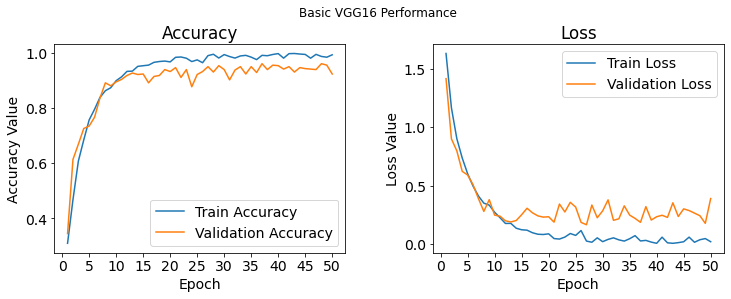

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic VGG16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


# Getting model predictions : Classification Report

In [20]:
# Getting model predictions
test_predictions = VGG16_model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90       310
           1       0.91      0.86      0.88       326
           2       0.99      0.92      0.95       419
           3       0.78      0.99      0.87       350

    accuracy                           0.90      1405
   macro avg       0.91      0.90      0.90      1405
weighted avg       0.92      0.90      0.91      1405



# Showing Confusion Matrix

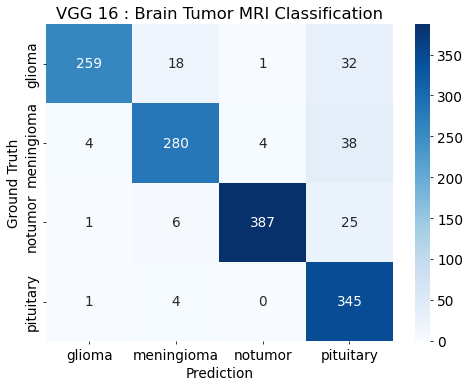

In [21]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('VGG 16 : Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

# Visualizing Model Predictions with Confidence

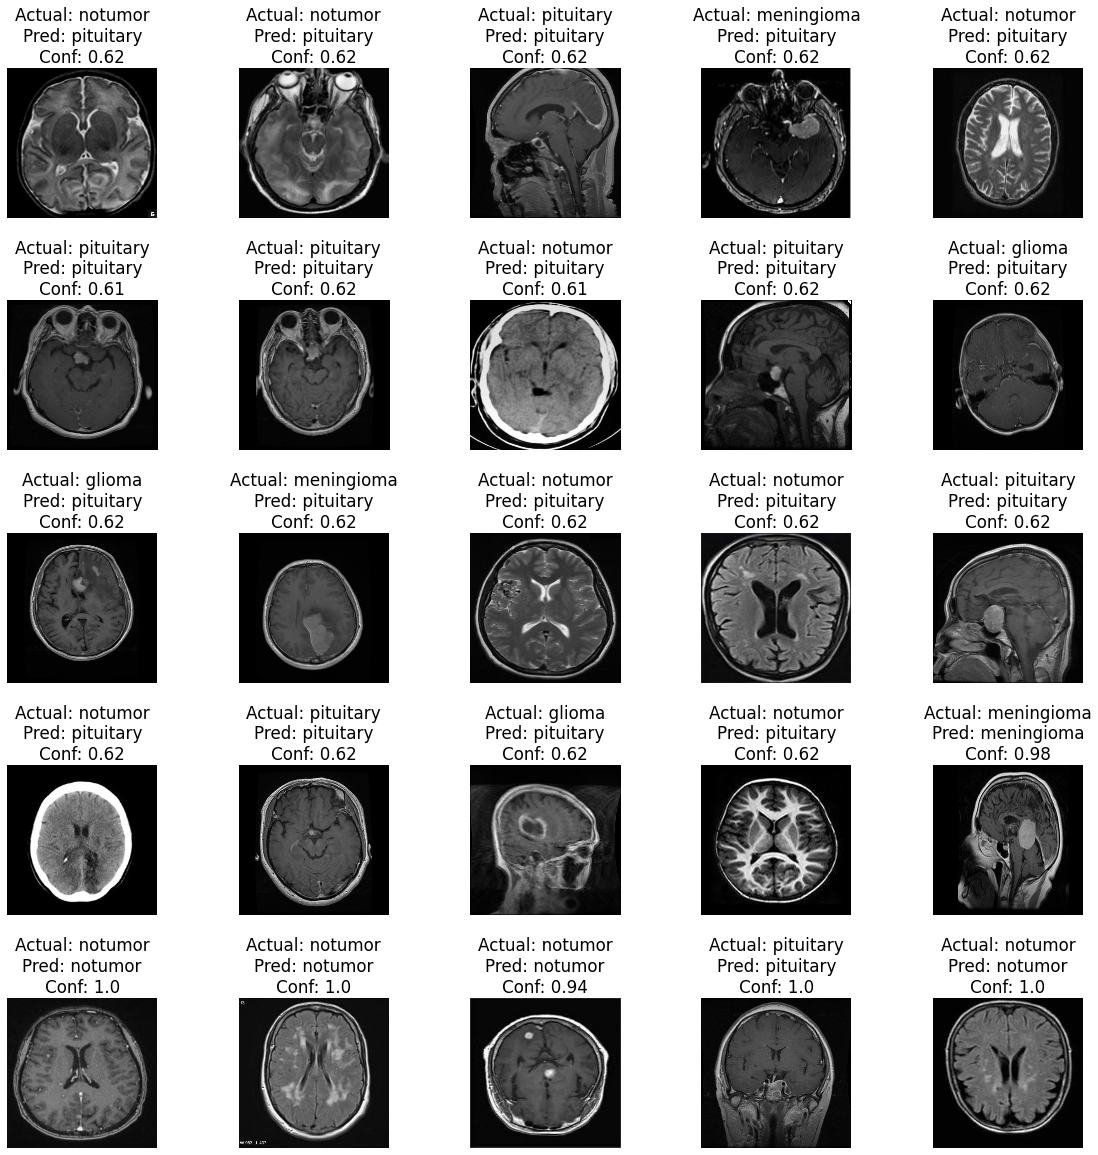

In [24]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = preds[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  